# Kalman Filter - 2D example

This notebook presents an example of a Kalman filter for a 2d case.

Key changes:

State $x$ redefined:
$$
x = \left(\begin{array}{cc}x \\ \Delta x \end{array}\right) 
-> \left(\begin{array}{cc}
x \\ 
\Delta x \\ 
y \\ 
\Delta y
\end{array}\right)
$$

Transition matrix $F$ redefined:
$$
F = \left(\begin{array}{cc}
x & \Delta x \\ . & \Delta x
\end{array}\right)
-> 
\left(\begin{array}{cc}
1.0 & 1.0 \\ . & 1.0
\end{array}\right)
-> 
\left(\begin{array}{cc}
x & \Delta x & . & . \\ 
. & \Delta x & . & . \\
. & . & y & \Delta y \\
. & . & . & \Delta y \\
\end{array}\right)
-> 
\left(\begin{array}{cc}
1.0 & 1.0 & . & . \\ 
. & 1.0 & . & . \\
. & . & 1.0 & 1.0 \\
. & . & . & 1.0 \\
\end{array}\right)
$$

Observation matrix $H$ redefined:
$$
H = 
\left(\begin{array}{cc}
x & . \\ . & \Delta x
\end{array}\right)
->
\left(\begin{array}{cc}
1.0 & . \\ . & 1.0
\end{array}\right)
->
\left(\begin{array}{cc}
x & . & . & . \\
. & \Delta x & . & . \\
. & . & y & . \\
. & . & . & \Delta y \\
\end{array}\right)
->
\left(\begin{array}{cc}
1.0 & . & . & . \\
. & 1.0 & . & . \\
. & . & 1.0 & . \\
. & . & . & 1.0 \\
\end{array}\right)
$$ 

In [1]:
%matplotlib inline
import numpy as np
import observations as obs
from covariance import CovarianceEstimator
import visualization as viz

## Example

Set initial assumptions:

- x0 - current location assumption
- dx0 - current speed / velocity assumption
- y0 - current location assumption
- dy0 - current speed / velocity assumption
- x_var0 - confidence in the initial location assumpiton - no impact on Kalman filter as long as initial value is high
- dx_var0 - confidence in the initial speed / velocity assumpiton - no impact on Kalman filter as long as initial value is high
- y_var0 - confidence in the initial location assumpiton - no impact on Kalman filter as long as initial value is high
- dy_var0 - confidence in the initial speed / velocity assumpiton - no impact on Kalman filter as long as initial value is high
- loc_measErr - location measurement noise
- v_measErr - velocity measuremnt noise

In [2]:
# Initial belief
x0 = 0.0
dx0 = 0.0
y0 = 0.0
dy0 = 0.0
# Confidence in initial belief
x_var0 = 100.0
dx_var0 = 100.0
y_var0 = 100.0
dy_var0 = 100.0
# Measurement noise
loc_measErr = 1.5
v_measErr = 0.25

In [3]:
F = np.matrix([
    [1., 1., 0., 0.],
    [0., 1., 0., 0.],
    [0., 0., 1., 1.],
    [0., 0., 0., 1.],
])
H = np.identity(F.shape[0], dtype=F.dtype)
I = np.identity(F.shape[0], dtype=F.dtype)

In [4]:
o = obs.Observations2d(start_x=10.0, start_y=6.0, decay_x=0.995, decay_y=0.985,
    noise_loc=loc_measErr, noise_vel=v_measErr
)
covar = CovarianceEstimator(n_dim=F.shape[0], dtype=F.dtype)
x_t0 = np.matrix([x0, dx0, y0, dy0]).T
R = np.matrix(np.diag(np.array(
    [50*loc_measErr**2, 50*v_measErr**2, 50*loc_measErr**2, 50*v_measErr**2]
)))
P = np.matrix(np.diag(np.array([x_var0, dx_var0, y_var0, dy_var0])))

In [5]:
results = dict(
    predictions = list(),
    pred_std = list(),
    observations = list()
)

for _ in range(100):

        # prediction step
        x_t1 = F * x_t0

        # update
        # - error
        z = np.matrix(o.get()).T
        y = z - H*x_t1

        # - Kalman gain
        # K = P / (P+R)
        S = H*P*H.T + R
        K = P*H.T * np.linalg.inv(S)

        # - state update
        # x[t] = x[t|t-1] * K*y
        x_t0 = x_t1 + K*y

        # - prediction error update
        # P = (1-K)*P
        P = (I - K*H)*P
        # P = P + Q
        Q = covar.eval(y)
        P = F*P*F.T + Q

        results['predictions'].append([
            float(x_t0[0,0]), float(x_t0[1,0]), float(x_t0[2,0]), float(x_t0[3,0])
        ])
        results['pred_std'].append([
            float(np.sqrt(Q[0,0])), float(np.sqrt(Q[1,1])), float(np.sqrt(Q[2,2])), float(np.sqrt(Q[3,3]))
        ])
        results['observations'].append([
            float(z[0,0]), float(z[1,0]), float(z[2,0]), float(z[3,0])
        ])

### Plot 1 - Observations vs Predicitons

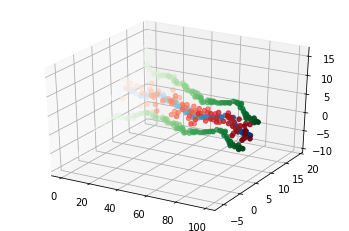

In [6]:
viz.plot_2d_results(**results, file_name=None)